In [6]:
import re
import os
import numpy as np
import nglview as nv
import matplotlib.pyplot as plt

from scipy.constants import physical_constants

from pymatgen.core import Structure
from pymatgen.io.vasp.outputs import Outcar

np.set_printoptions(suppress=True, linewidth=100000)
plt.rcParams.update({'font.size': 20})

def re_int(string_sub, string_search):
    return int(re.sub(string_sub, '', re.search(r'%s\d+' % (string_sub), string_search).group()))

def re_float(string_sub, string_search):
    return float(re.sub(string_sub, '', re.search(r'%s[-]?\d+[.]\d+' % (string_sub), string_search).group()))

def print_hamiltonian(path_hamiltonian):
    N  = re_int('N',  path_hamiltonian)
    Ne = re_int('Ne', path_hamiltonian)
    U  = re_float('U', path_hamiltonian)
    
    hamiltonian = np.zeros((N, N), dtype='complex')
    for data in np.genfromtxt(path_hamiltonian):
        hamiltonian[int(data[0]), int(data[1])] = data[2] + 1j * data[3]
    print(hamiltonian.real)
    
def show_E_U(dir_output, method=['soft', 'qsoft']):
    system, params = dir_output.split('/')[::2]
    marker = ['none', 'o']
    linestyle=['-', 'none']
    
    data = [[] for _ in range(len(method))]
    for i, m in enumerate(method):
        for fn in [fn for fn in os.listdir(dir_output) if re.match(f'{m}_hamiltonian', fn)]:
            data[i].append([re_float('_U', fn), re_float('_e', fn)])
        data[i] = np.sort(data[i], axis=0)
    data = np.array(data)

    fig, ax = plt.subplots(constrained_layout=True)
    for d, m, mk, ls in zip(data, method, marker, linestyle):
        ax.plot(d[:, 0], d[:, 1], marker=mk, linestyle=ls, label=f'{m.upper()}')
    ax.set_xlabel(r'$U/t$')
    ax.set_ylabel(r'$E/t$')
    ax.set_title(re.sub('_', ' ', f'{system} {params}'), fontsize='medium')
    ax.legend(fontsize='x-small')
    ax.grid(True)
    plt.show()
    
def show_E_R(dir_output, method=['dft', 'qdft']):
    system, params = dir_output.split('/')[::2]
    marker = ['none', 'o']
    linestyle=['-', 'none']

    ev2ht = physical_constants['electron volt-hartree relationship'][0]
    
    data = [[] for _ in range(len(method))]
    for i, m in enumerate(method):
        for dn in [dn for dn in os.listdir(dir_output) if re.match(f'{m}_R', dn)]:
            fn = f'{dir_output}/{dn}/OUTCAR'
            if os.path.isfile(fn):
                data[i].append([re_float('_R', dn), Outcar(fn).final_energy * ev2ht])
        data[i] = np.sort(data[i], axis=0)
    data = np.array(data)

    fig, ax = plt.subplots(constrained_layout=True)
    for d, m, mk, ls in zip(data, method, marker, linestyle):
        ax.plot(d[:, 0], d[:, 1], marker=mk, linestyle=ls, label=f'{m.upper()}')
    ax.set_xlabel(r'$R$')
    ax.set_ylabel(r'$E$ (Hartree)')
    ax.set_title(re.sub('_', ' ', f'{system} {params}'), fontsize='medium')
    ax.legend(fontsize='x-small')
    ax.grid(True)
    plt.show()

def show_poscar(dir_output):
    structure = Structure.from_file(f'{dir_output}/POSCAR')
    view = nv.show_pymatgen(structure)
    return view

# hub1d

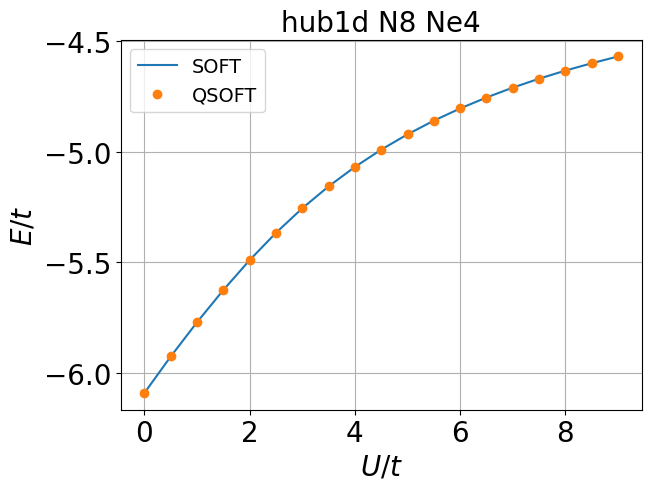

In [2]:
show_E_U('hub1d/output/N8_Ne4', method=['soft', 'qsoft'])

# hchain

In [7]:
show_poscar('hchain/output/N8/dft_R2.00')

NGLWidget()

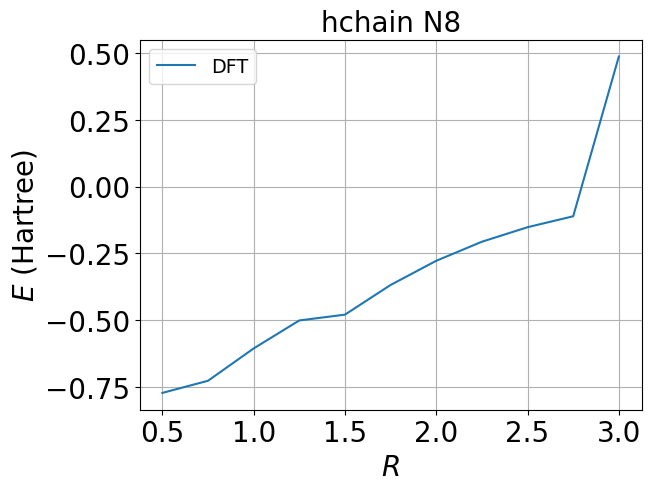

In [8]:
show_E_R('hchain/output/N8', method=['dft'])